# ClickHouse данные в Python

## Задания

In [1]:
import pandahouse as ph
import pandas as pd

In [2]:
#объявляем параметры подключения
connection_default = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'default',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

### 1

In [5]:
#записывалась в clickhouse_connect.ipynb
query_test = """
SELECT 
    room_type,
    toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) AS price
FROM default.ldn_listings
ORDER BY id ASC
LIMIT 1000 
"""
airbnb_london = ph.read_clickhouse(query_test, connection=connection_default)
airbnb_london

,room_type,price
0,Private room,65.0
1,Entire home/apt,100.0
2,Entire home/apt,300.0
3,Private room,150.0
4,Entire home/apt,65.0
...,...,...
995,Entire home/apt,110.0
996,Entire home/apt,110.0
997,Private room,65.0
998,Entire home/apt,100.0


In [7]:
airbnb_london.groupby('room_type', as_index=False).price.quantile(q=0.75)

,room_type,price
0,Entire home/apt,160.00
1,Hotel room,157.00
2,Private room,70.00
3,Shared room,69.25


### 4

In [8]:
query_test = """
SELECT 
    room_type,
    toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) AS price,
    toFloat32OrNull(review_scores_rating) AS review_scores_rating
FROM default.ldn_listings
WHERE review_scores_rating != 0
ORDER BY id ASC
LIMIT 1000 
"""
airbnb_london_4 = ph.read_clickhouse(query_test, connection=connection_default)
airbnb_london_4

,room_type,price,review_scores_rating
0,Private room,65.0,97.0
1,Entire home/apt,100.0,96.0
2,Entire home/apt,300.0,94.0
3,Entire home/apt,65.0,93.0
4,Private room,29.0,96.0
...,...,...,...
995,Entire home/apt,165.0,100.0
996,Private room,99.0,93.0
997,Private room,45.0,100.0
998,Private room,20.0,88.0


In [11]:
avg_price_review = airbnb_london_4.groupby('room_type', as_index=False).agg({'price': 'mean', 'review_scores_rating': 'mean'})

In [10]:
import seaborn as sns

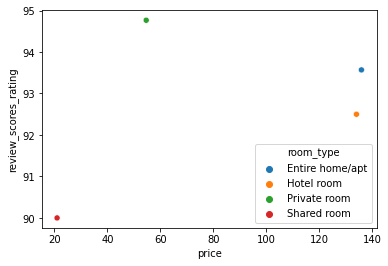

In [12]:
sns.scatterplot(x='price', y='review_scores_rating', hue='room_type', data=avg_price_review)

### 5

In [13]:
query_test = """
SELECT 
    host_id,
    host_verifications
FROM default.ldn_listings
WHERE experiences_offered != 'none'
"""
airbnb_london_5 = ph.read_clickhouse(query_test, connection=connection_default)
airbnb_london_5

,host_id,host_verifications
0,54730,"['email', 'phone', 'facebook', 'reviews', 'off..."
1,60302,"['email', 'phone', 'reviews', 'jumio', 'govern..."
2,67915,"['email', 'phone', 'jumio', 'selfie', 'governm..."
3,167107,"['email', 'phone', 'manual_offline', 'jumio', ..."
4,103583,"['email', 'phone', 'reviews', 'offline_governm..."
...,...,...
1543,34219613,"['email', 'phone', 'reviews', 'jumio', 'govern..."
1544,2730552,"['email', 'phone', 'facebook', 'jumio', 'offli..."
1545,34299581,"['email', 'phone', 'google', 'reviews', 'jumio..."
1546,2730552,"['email', 'phone', 'facebook', 'jumio', 'offli..."


In [25]:
airbnb_london_5['host_verifications'] = airbnb_london_5.host_verifications.apply(lambda x: x.strip().replace("'", "").replace("[", "").replace("]", "").replace(" ", "").split(','))

In [34]:
airbnb_london_5.explode('host_verifications').query('host_verifications == "google"').host_id.nunique()

34

### 6

In [35]:
query_test = """
SELECT 
    neighbourhood_cleansed,
    experiences_offered,
    COUNT(experiences_offered) AS experiences_count
FROM default.ldn_listings
WHERE experiences_offered != 'none'

GROUP BY 
    neighbourhood_cleansed,
    experiences_offered

ORDER BY experiences_count DESC

LIMIT 100
"""
airbnb_london_6 = ph.read_clickhouse(query_test, connection=connection_default)
airbnb_london_6

,neighbourhood_cleansed,experiences_offered,experiences_count
0,Hackney,family,61
1,Tower Hamlets,business,58
2,Westminster,business,50
3,Hackney,social,49
4,Hammersmith and Fulham,business,48
...,...,...,...
95,Redbridge,social,2
96,Barking and Dagenham,social,2
97,Newham,romantic,1
98,Bexley,business,1


In [39]:
experiences_offered_by_district = airbnb_london_6.pivot(index='neighbourhood_cleansed', columns='experiences_offered', values='experiences_count').fillna(0)

In [40]:
experiences_offered_by_district

experiences_offered,business,family,romantic,social
neighbourhood_cleansed,,,,
Barking and Dagenham,0.0,0.0,0.0,2.0
Barnet,7.0,7.0,3.0,5.0
Bexley,1.0,0.0,0.0,0.0
Brent,9.0,21.0,5.0,6.0
Bromley,3.0,2.0,0.0,4.0
Camden,36.0,30.0,19.0,25.0
City of London,7.0,1.0,0.0,0.0
Croydon,2.0,3.0,0.0,4.0
Ealing,6.0,13.0,0.0,5.0


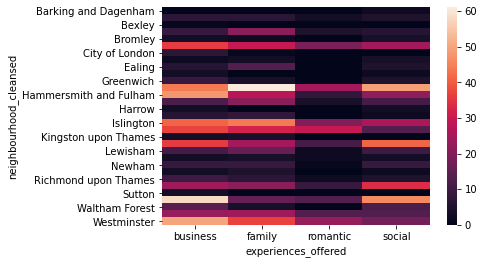

In [43]:
sns.heatmap(experiences_offered_by_district, annot=False)
cmap=sns.cubehelix_palette(as_cmap=True)

### 7

In [44]:
query_test = """
SELECT 
    room_type,
    toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) AS price
FROM default.ldn_listings
WHERE experiences_offered != 'none'
"""
airbnb_london_7 = ph.read_clickhouse(query_test, connection=connection_default)
airbnb_london_7

,room_type,price
0,Private room,65.0
1,Entire home/apt,100.0
2,Private room,150.0
3,Private room,45.0
4,Private room,25.0
...,...,...
1543,Entire home/apt,100.0
1544,Entire home/apt,125.0
1545,Entire home/apt,185.0
1546,Entire home/apt,110.0


In [48]:
airbnb_london_7.room_type.unique()

array(['Private room', 'Entire home/apt', 'Hotel room', 'Shared room'],
      dtype=object)

In [56]:
import matplotlib.pyplot as plt
import numpy as np

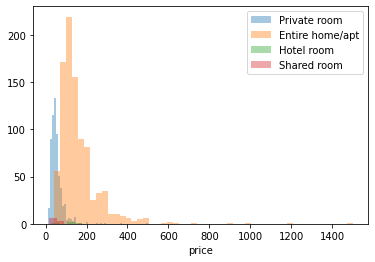

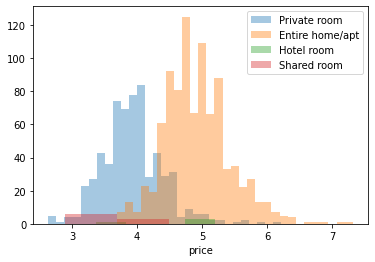

In [61]:
sns.distplot(airbnb_london_7.query("room_type == 'Private room'").price, kde=False, label='Private room')
sns.distplot(airbnb_london_7.query("room_type == 'Entire home/apt'").price, kde=False, label='Entire home/apt')
sns.distplot(airbnb_london_7.query("room_type == 'Hotel room'").price, kde=False, label='Hotel room')
sns.distplot(airbnb_london_7.query("room_type == 'Shared room'").price, kde=False, label='Shared room')
plt.legend()
plt.show()

sns.distplot(np.log(airbnb_london_7.query("room_type == 'Private room'").price), kde=False, label='Private room')
sns.distplot(np.log(airbnb_london_7.query("room_type == 'Entire home/apt'").price), kde=False, label='Entire home/apt')
sns.distplot(np.log(airbnb_london_7.query("room_type == 'Hotel room'").price), kde=False, label='Hotel room')
sns.distplot(np.log(airbnb_london_7.query("room_type == 'Shared room'").price), kde=False, label='Shared room')
plt.legend()
plt.show()

### 8

In [69]:
query_test = """
SELECT 
    room_type,
    toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) AS price,
    first_review
FROM default.ldn_listings
WHERE first_review > '2010-01-01'
LIMIT 1000
"""
airbnb_london_8 = ph.read_clickhouse(query_test, connection=connection_default)
airbnb_london_8

,room_type,price,first_review
0,Private room,65.0,2010-08-18
1,Entire home/apt,300.0,2011-03-21
2,Entire home/apt,65.0,2016-03-05
3,Private room,29.0,2010-04-14
4,Private room,100.0,2010-10-16
...,...,...,...
995,Private room,45.0,2012-11-07
996,Private room,51.0,2013-03-18
997,Entire home/apt,79.0,2012-09-17
998,Entire home/apt,110.0,2012-09-24


In [72]:
airbnb_london_8['first_review'] = pd.to_datetime(airbnb_london_8.first_review)

In [75]:
import datetime

In [79]:
airbnb_london_8['year'] = pd.DatetimeIndex(airbnb_london_8['first_review']).year

In [83]:
avg_price_by_year = airbnb_london_8.groupby(['room_type', 'year'], as_index=False).agg({'price': 'mean'}).sort_values('year')

In [84]:
avg_price_by_year

,room_type,year,price
0,Entire home/apt,2010,103.500000
13,Private room,2010,56.428570
11,Hotel room,2010,88.000000
1,Entire home/apt,2011,128.792450
14,Private room,2011,52.607143
2,Entire home/apt,2012,135.467255
15,Private room,2012,53.269840
24,Shared room,2012,22.000000
3,Entire home/apt,2013,137.887634
16,Private room,2013,57.036587


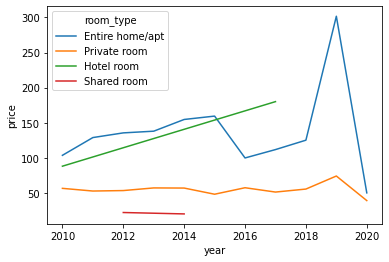

In [86]:
sns.lineplot(data=avg_price_by_year, x='year', y='price', hue='room_type')